<a href="https://colab.research.google.com/github/vijishmadhavan/Palette/blob/master/Palette_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#@title Inputs { display-mode: "form" }

from torchvision import models
import torch
import torchvision.transforms as T
import math
import PIL
import numpy as np
import cv2
from google.colab.patches import cv2_imshow
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt 


import warnings
warnings.filterwarnings('ignore')

dlab = models.segmentation.deeplabv3_resnet101(pretrained=1).eval()

def fetch_image(image_path):
  #urllib.request.urlretrieve(image_path, "image")
  img = PIL.Image.open(image_path)
  return img

def get_colors(image_file, numcolors=10, resize=150):
    # Resize image to speed up processing
    img = image_file.copy()
    img.thumbnail((resize, resize))

    # Reduce to palette
    paletted = img.convert('P', palette=Image.ADAPTIVE, colors=numcolors)

    # Find dominant colors
    palette = paletted.getpalette()
    color_counts = sorted(paletted.getcolors(), reverse=True)
    colors = list()
    for i in range(numcolors):
        palette_index = color_counts[i][1]
        dominant_color = palette[palette_index*3:palette_index*3+3]
        colors.append(tuple(dominant_color))

    return colors

def decode_segmap(image, nc=21):
  
  label_colors = np.array([(0, 0, 0),  # 0=background
               # 1=aeroplane, 2=bicycle, 3=bird, 4=boat, 5=bottle
               (255, 255, 255), (255, 255, 255), (255, 255, 255), (255, 255, 255), (255, 255, 255),
               # 6=bus, 7=car, 8=cat, 9=chair, 10=cow
               (255, 255, 255), (255, 255, 255), (255, 255, 255), (255, 255, 255), (255, 255, 255),
               # 11=dining table, 12=dog, 13=horse, 14=motorbike, 15=person
               (255, 255, 255), (255, 255, 255), (255, 255, 255), (255, 255, 255), (255, 255, 255),
               # 16=potted plant, 17=sheep, 18=sofa, 19=train, 20=tv/monitor
               (255, 255, 255), (255, 255, 255), (255, 255, 255), (255, 255, 255), (255, 255, 255)])

  r = np.zeros_like(image).astype(np.uint8)
  g = np.zeros_like(image).astype(np.uint8)
  b = np.zeros_like(image).astype(np.uint8)
  
  for l in range(0, nc):
    idx = image == l
    r[idx] = label_colors[l, 0]
    g[idx] = label_colors[l, 1]
    b[idx] = label_colors[l, 2]
    
  rgb = np.stack([r, g, b], axis=2)
  return rgb



Downloading: "https://download.pytorch.org/models/deeplabv3_resnet101_coco-586e9e4e.pth" to /root/.cache/torch/hub/checkpoints/deeplabv3_resnet101_coco-586e9e4e.pth


  0%|          | 0.00/233M [00:00<?, ?B/s]

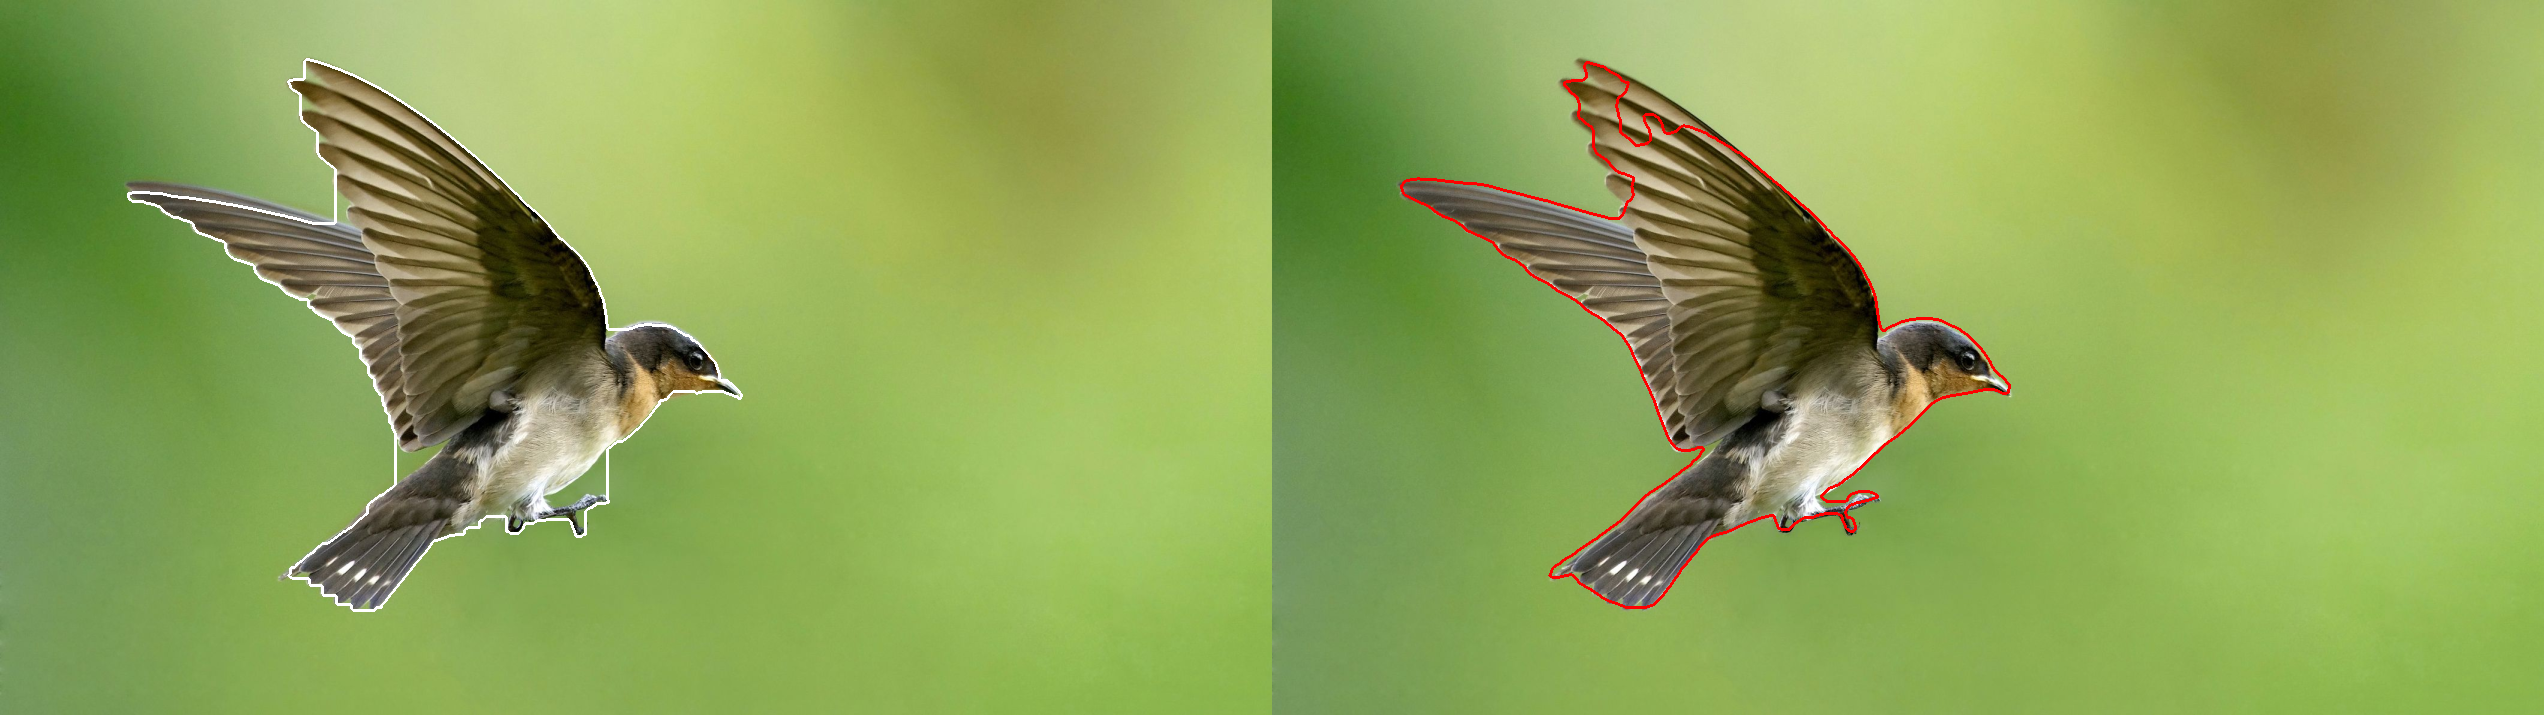

In [2]:
#@title Polyline drawn { display-mode: "form" }
path = '/content/swallowGE-57a109323df78c3276f5b8a0.jpg' #@param {type:"string"}

# load the image, convert it to grayscale, and blur it
image = cv2.imread(path)


dimensions = image.shape
 
# height, width, number of channels in image
height = image.shape[0]
if height > 1000:
  scale_percent = 60 # percent of original size
  width = int(image.shape[1] * scale_percent / 100)
  height = int(image.shape[0] * scale_percent / 100)
  dim = (width, height)
  
# resize image
  image = cv2.resize(image, dim, interpolation = cv2.INTER_AREA)

else:
  pass
img1 = image.copy()
img = Image.fromarray(image)

trf = T.Compose([#T.Resize(640), 
                   #T.CenterCrop(224), 
                   T.ToTensor(), 
                   T.Normalize(mean = [0.485, 0.456, 0.406], 
                               std = [0.229, 0.224, 0.225])])
dev='cuda'
inp = trf(img).unsqueeze(0).to(dev)
out = dlab.to(dev)(inp)['out']
om = torch.argmax(out.squeeze(), dim=0).detach().cpu().numpy()
rgb = decode_segmap(om)
edged = cv2.Canny(rgb, 30, 200)
contours, hierarchies = cv2.findContours(edged,cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)
big_contour = max(contours, key=cv2.contourArea)
a2 = cv2.drawContours(img1, big_contour, -1, (0,0,255), 2)  
#cv2_imshow(a)




gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
gray = cv2.GaussianBlur(gray, (3, 3), 0)
edged = cv2.Canny(gray, 20, 250)
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (20, 50))
closed = cv2.morphologyEx(edged, cv2.MORPH_CLOSE, kernel)
contours, hierarchies = cv2.findContours(closed,cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)
#contours = contours[0] if len(contours) == 2 else contours[1]
big_contour = max(contours, key=cv2.contourArea)
result = np.zeros_like(image)


cv2.drawContours(result, [big_contour], 0, (255,255,255), cv2.FILLED)
b = cv2.drawContours(image, big_contour, -1, (255,255,255), 2)

Hori = np.concatenate((b, a2), axis=1)



cv2_imshow(Hori)


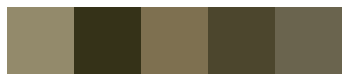

In [3]:
#@title Color Palette { display-mode: "form" }

final = cv2.bitwise_and(image, result)
cv2.imwrite("final.jpg",final)
a = fetch_image("final.jpg")


colors = a = get_colors(a,numcolors=10, resize=150)

c = colors[2:7]
palette = np.array(c)[np.newaxis, :, :]
plt.axis('off')

plt.imshow(palette)
